In [ ]:
#比較線性 SVM
#核技巧 SVM 
#使用 PolynomialCountSketch（PS）特徵轉換後的線性 SVM 的效能與訓練時間差異。

## Introduction
This lab will demonstrate how to use polynomial kernel approximation in scikit-learn to efficiently generate polynomial kernel feature-space approximations. This is used to train linear classifiers that approximate the accuracy of kernelized ones. We will be using the Covtype dataset, which contains 581,012 samples with 54 features each, distributed among 6 classes. The goal of this dataset is to predict forest cover type from cartographic variables only (no remotely sensed data). After loading, we transform it into a binary classification problem to match the version of the dataset in the LIBSVM webpage, which was the one used in the original paper.

這個實驗要教你怎麼用 scikit-learn 中的「多項式核近似法（polynomial kernel approximation）」來產生新的特徵，讓你可以用簡單的線性分類器（例如線性 SVM）去模仿原本複雜的「核方法」的效果。

### 資料集介紹：
- 使用的資料叫做 Covtype。
- 這個資料集有 581,012 筆資料，每筆有 54 個特徵。
- 原本有 6 種森林覆蓋類型（也就是 6 類分類問題）。

### 處理方式：
- 為了簡化，我們只保留其中一類，轉換成 **二元分類問題**（只有「是」或「不是」某一類）。
- 這樣的設定是為了跟 LIBSVM 官方網站提供的版本一致，方便做比較。

簡單來說，我們的目標是：
用「近似多項式核」的方法，把資料轉成新特徵後，再用快速的線性分類器來達到類似複雜模型的效果。

## Load and Prepare the Data
We will first load the Covtype dataset and transform it into a binary classification problem by selecting only one class. Then, we will partition the data into a training set and a testing set, and normalize the features.

In [3]:
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.pipeline import make_pipeline

# Load the Covtype dataset, selecting only one class
# 1. 載入並預處理資料（只取類別 2 當作正類，其餘為負類）
X, y = fetch_covtype(return_X_y=True)
y[y != 2] = 0
y[y == 2] = 1

# Partition the data into a training set and a testing set
# 分割資料集（控制樣本數，平衡速度與穩定性）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=5000, test_size=10000, random_state=42
)

# Normalize the features
mm = make_pipeline(MinMaxScaler(), Normalizer())
X_train = mm.fit_transform(X_train)
X_test = mm.transform(X_test)

## Establish a Baseline Model
## 建立基礎模型（Baseline: Linear SVM）
We will train a linear SVM on the original features to establish a baseline model and print its accuracy.



In [4]:
from sklearn.svm import LinearSVC

# Train a linear SVM on the original features
lsvm = LinearSVC(dual="auto")
lsvm.fit(X_train, y_train)
lsvm_score = 100 * lsvm.score(X_test, y_test)

# Print the accuracy of the baseline model
print(f"Linear SVM score on raw features: {lsvm_score:.2f}%")

Linear SVM score on raw features: 75.62%


## Establish the Kernel Approximation Model
## 使用 PolynomialCountSketch 建立近似模型
We will now train linear SVMs on features generated by PolynomialCountSketch with different values for n_components. We will use a loop to iterate through different values for n_components and print the accuracy of each model.

In [5]:
from sklearn.kernel_approximation import PolynomialCountSketch

n_runs = 1
N_COMPONENTS = [250, 500, 1000, 2000]

for n_components in N_COMPONENTS:
    ps_lsvm_score = 0
    for _ in range(n_runs):
        # Train a linear SVM on features generated by PolynomialCountSketch
        pipeline = make_pipeline(
            PolynomialCountSketch(n_components=n_components, degree=4),
            LinearSVC(dual="auto"),
        )
        pipeline.fit(X_train, y_train)
        ps_lsvm_score += 100 * pipeline.score(X_test, y_test)

    ps_lsvm_score /= n_runs

    # Print the accuracy of the model
    print(f"Linear SVM score on {n_components} PolynomialCountSketch features: {ps_lsvm_score:.2f}%")

Linear SVM score on 250 PolynomialCountSketch features: 76.38%
Linear SVM score on 500 PolynomialCountSketch features: 77.41%
Linear SVM score on 1000 PolynomialCountSketch features: 77.52%
Linear SVM score on 2000 PolynomialCountSketch features: 78.27%


## Establish the Kernelized SVM Model
## 建立 Kernel-SVM 模型（用真實的 kernel）
We will train a kernelized SVM to see how well PolynomialCountSketch is approximating the performance of the kernel.

In [7]:
from sklearn.svm import SVC

# Train a kernelized SVM
ksvm = SVC(C=500.0, kernel="poly", degree=4, coef0=0, gamma=1.0)
ksvm.fit(X_train, y_train)
ksvm_score = 100 * ksvm.score(X_test, y_test)

# Print the accuracy of the kernelized SVM
print(f"Kernel-SVM score on raw features: {ksvm_score:.2f}%")

Kernel-SVM score on raw features: 79.78%


##　Compare the Results
We will plot the results of the different methods against their training times to compare their performance.

In [12]:
results = {}

# 訓練 Linear SVM，並紀錄時間和分數
import time
start = time.time()
lsvm = LinearSVC(dual="auto")
lsvm.fit(X_train, y_train)
end = time.time()

lsvm_time = end - start
lsvm_score = 100 * lsvm.score(X_test, y_test)

results["Linear SVM"] = {"time": lsvm_time, "score": lsvm_score}


# 訓練 PolynomialCountSketch 不同 n_components，並存結果
from sklearn.kernel_approximation import PolynomialCountSketch
from sklearn.pipeline import make_pipeline

N_COMPONENTS = [250, 500, 1000, 2000]

for n_components in N_COMPONENTS:
    start = time.time()
    pipeline = make_pipeline(
        PolynomialCountSketch(n_components=n_components, degree=4),
        LinearSVC(dual="auto"),
    )
    pipeline.fit(X_train, y_train)
    end = time.time()
    score = 100 * pipeline.score(X_test, y_test)
    elapsed = end - start

    results[f"LSVM + PS({n_components})"] = {"time": elapsed, "score": score}


# 訓練 Kernel SVM
from sklearn.svm import SVC

start = time.time()
ksvm = SVC(C=500.0, kernel="poly", degree=4, coef0=0, gamma=1.0)
ksvm.fit(X_train, y_train)
end = time.time()

ksvm_time = end - start
ksvm_score = 100 * ksvm.score(X_test, y_test)

results["Kernel SVM"] = {"time": ksvm_time, "score": ksvm_score}

print(results)

{'Linear SVM': {'time': 0.020380258560180664, 'score': 75.62}, 'LSVM + PS(250)': {'time': 0.5829083919525146, 'score': 75.86}, 'LSVM + PS(500)': {'time': 1.1531107425689697, 'score': 77.19}, 'LSVM + PS(1000)': {'time': 2.31807279586792, 'score': 78.07}, 'LSVM + PS(2000)': {'time': 4.824726343154907, 'score': 78.62}, 'Kernel SVM': {'time': 2.5206856727600098, 'score': 79.78}}


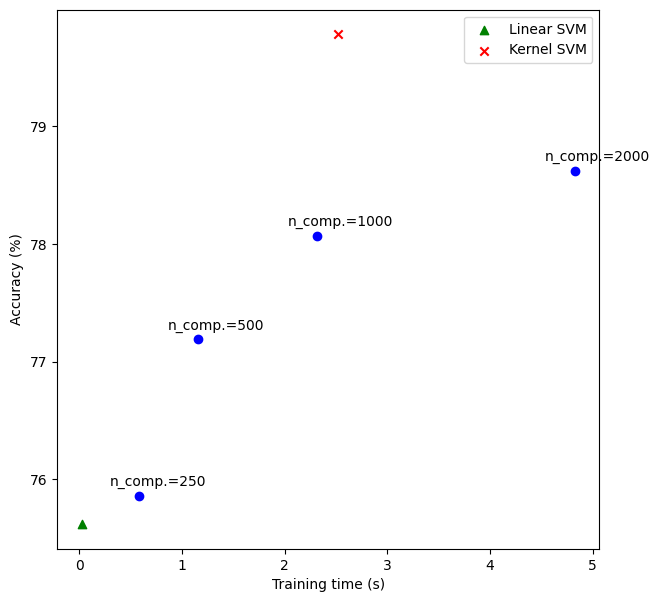

In [13]:
import matplotlib.pyplot as plt

# Plot the results of the different methods
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    [
        lsvm_time,
    ],
    [
        lsvm_score,
    ],
    label="Linear SVM",
    c="green",
    marker="^",
)

for n_components in N_COMPONENTS:
    ax.scatter(
        [
            results[f"LSVM + PS({n_components})"]["time"],
        ],
        [
            results[f"LSVM + PS({n_components})"]["score"],
        ],
        c="blue",
    )
    ax.annotate(
        f"n_comp.={n_components}",
        (
            results[f"LSVM + PS({n_components})"]["time"],
            results[f"LSVM + PS({n_components})"]["score"],
        ),
        xytext=(-30, 10),
        textcoords="offset pixels",
    )

ax.scatter(
    [
        ksvm_time,
    ],
    [
        ksvm_score,
    ],
    label="Kernel SVM",
    c="red",
    marker="x",
)

ax.set_xlabel("Training time (s)")
ax.set_ylabel("Accuracy (%)")
ax.legend()
plt.show()

## Summary
This lab demonstrated how to use polynomial kernel approximation in scikit-learn to efficiently generate polynomial kernel feature-space approximations. We applied this technique to the Covtype dataset, transforming it into a binary classification problem and training linear classifiers that approximate the accuracy of kernelized ones. We also compared the performance of the different methods and plotted the results against their training times.

[Linear SVM] Accuracy: 75.62%, Time: 0.02s
[PS-250] Accuracy: 76.48%, Time: 0.64s
[PS-500] Accuracy: 77.29%, Time: 1.29s
[PS-1000] Accuracy: 77.84%, Time: 2.39s
[PS-2000] Accuracy: 78.24%, Time: 4.70s
[Kernel SVM] Accuracy: 78.63%, Time: 0.82s


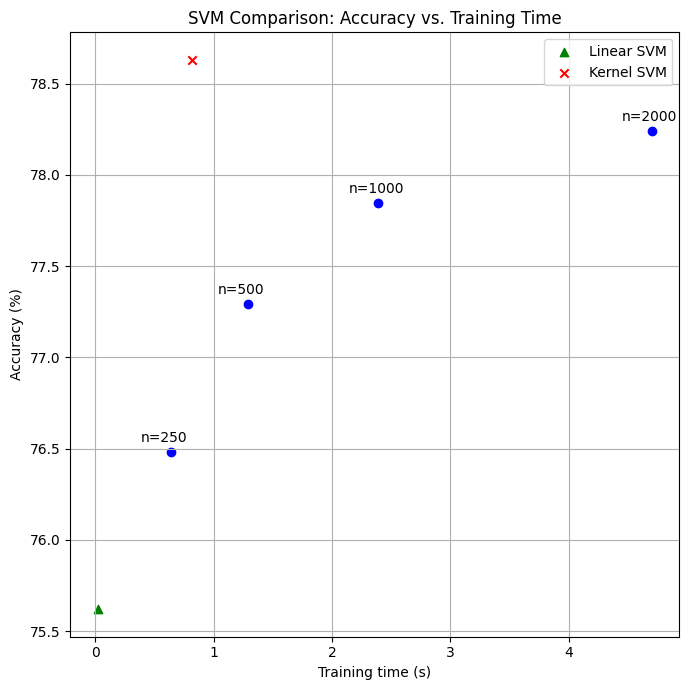

In [14]:
import time
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.kernel_approximation import PolynomialCountSketch

# 1. 載入並預處理資料（只取類別 2 當作正類，其餘為負類）
X, y = fetch_covtype(return_X_y=True)
y = (y == 2).astype(int)

# 分割資料集（控制樣本數，平衡速度與穩定性）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=5000, test_size=10000, random_state=42
)

# 特徵縮放與正規化
scaler = make_pipeline(MinMaxScaler(), Normalizer())
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 儲存結果的 dict
results = {}

# 訓練 Linear SVM（baseline）
start = time.time()
lsvm = LinearSVC(dual="auto", C=1.0, max_iter=10000)
lsvm.fit(X_train, y_train)
end = time.time()

lsvm_score = 100 * lsvm.score(X_test, y_test)
lsvm_time = end - start
results["Linear SVM"] = {"time": lsvm_time, "score": lsvm_score}
print(f"[Linear SVM] Accuracy: {lsvm_score:.2f}%, Time: {lsvm_time:.2f}s")

# PolynomialCountSketch 特徵映射 + Linear SVM
N_COMPONENTS = [250, 500, 1000, 2000]
n_runs = 3  # 增加穩定性，可調整

for n_components in N_COMPONENTS:
    total_time = 0
    total_score = 0
    for _ in range(n_runs):
        pipeline = make_pipeline(
            PolynomialCountSketch(n_components=n_components, degree=4),
            LinearSVC(dual="auto", C=1.0, max_iter=10000),
        )
        start = time.time()
        pipeline.fit(X_train, y_train)
        end = time.time()
        score = 100 * pipeline.score(X_test, y_test)
        total_time += (end - start)
        total_score += score

    avg_time = total_time / n_runs
    avg_score = total_score / n_runs
    results[f"LSVM + PS({n_components})"] = {"time": avg_time, "score": avg_score}
    print(f"[PS-{n_components}] Accuracy: {avg_score:.2f}%, Time: {avg_time:.2f}s")

# 核 SVM（Polynomial Kernel，degree=4）
# 注意 C 值設為較合理的數值（避免過擬合）
start = time.time()
ksvm = SVC(C=1.0, kernel="poly", degree=4, coef0=1.0, gamma="scale")
ksvm.fit(X_train, y_train)
end = time.time()

ksvm_score = 100 * ksvm.score(X_test, y_test)
ksvm_time = end - start
results["Kernel SVM"] = {"time": ksvm_time, "score": ksvm_score}
print(f"[Kernel SVM] Accuracy: {ksvm_score:.2f}%, Time: {ksvm_time:.2f}s")

# 畫出準確率 vs 時間的圖
fig, ax = plt.subplots(figsize=(7, 7))

# Linear SVM 點
ax.scatter(
    [results["Linear SVM"]["time"]],
    [results["Linear SVM"]["score"]],
    label="Linear SVM",
    c="green",
    marker="^"
)

# PS 特徵映射點
for n_components in N_COMPONENTS:
    label = f"LSVM + PS({n_components})"
    ax.scatter(
        [results[label]["time"]],
        [results[label]["score"]],
        c="blue"
    )
    ax.annotate(
        f"n={n_components}",
        (results[label]["time"], results[label]["score"]),
        xytext=(-30, 10),
        textcoords="offset pixels",
    )

# 核 SVM 點
ax.scatter(
    [results["Kernel SVM"]["time"]],
    [results["Kernel SVM"]["score"]],
    label="Kernel SVM",
    c="red",
    marker="x"
)

ax.set_xlabel("Training time (s)")
ax.set_ylabel("Accuracy (%)")
ax.set_title("SVM Comparison: Accuracy vs. Training Time")
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


[Linear SVM] Accuracy: 75.62%, Time: 0.02s
[LSVM + PS(250)] Accuracy: 76.42%, Time: 0.58s
[LSVM + PS(500)] Accuracy: 77.59%, Time: 1.20s
[LSVM + PS(1000)] Accuracy: 78.05%, Time: 2.38s
[LSVM + PS(2000)] Accuracy: 78.32%, Time: 4.55s
[Kernel SVM (Poly)] Best params: {'C': 10, 'coef0': 1.0, 'degree': 4, 'gamma': 'scale'}
[Kernel SVM (Poly)] Accuracy: 80.00%, Time: 36.47s
[Kernel SVM (RBF)] Best params: {'C': 10, 'gamma': 'scale'}
[Kernel SVM (RBF)] Accuracy: 78.52%, Time: 12.26s


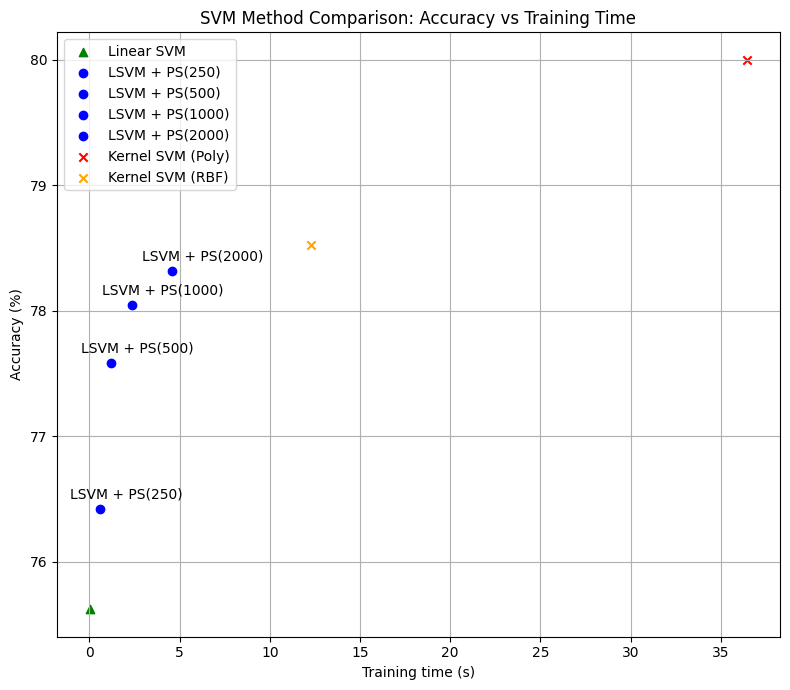

In [15]:
import time
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.kernel_approximation import PolynomialCountSketch

# === 資料預處理 ===
X, y = fetch_covtype(return_X_y=True)
y = (y == 2).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=5000, test_size=10000, random_state=42
)

scaler = make_pipeline(MinMaxScaler(), Normalizer())
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

results = {}

# === Linear SVM ===
start = time.time()
lsvm = LinearSVC(dual="auto", C=1.0, max_iter=10000)
lsvm.fit(X_train, y_train)
end = time.time()

lsvm_score = 100 * lsvm.score(X_test, y_test)
lsvm_time = end - start
results["Linear SVM"] = {"time": lsvm_time, "score": lsvm_score}
print(f"[Linear SVM] Accuracy: {lsvm_score:.2f}%, Time: {lsvm_time:.2f}s")

# === Polynomial Count Sketch + Linear SVM ===
N_COMPONENTS = [250, 500, 1000, 2000]
n_runs = 3

for n_components in N_COMPONENTS:
    total_time = 0
    total_score = 0
    for _ in range(n_runs):
        pipeline = make_pipeline(
            PolynomialCountSketch(n_components=n_components, degree=4),
            LinearSVC(dual="auto", C=1.0, max_iter=10000),
        )
        start = time.time()
        pipeline.fit(X_train, y_train)
        end = time.time()
        score = 100 * pipeline.score(X_test, y_test)
        total_time += (end - start)
        total_score += score

    avg_time = total_time / n_runs
    avg_score = total_score / n_runs
    label = f"LSVM + PS({n_components})"
    results[label] = {"time": avg_time, "score": avg_score}
    print(f"[{label}] Accuracy: {avg_score:.2f}%, Time: {avg_time:.2f}s")

# === Polynomial Kernel SVM + GridSearchCV ===
poly_param_grid = {
    "C": [0.1, 1, 10],
    "degree": [2, 3, 4],
    "gamma": ["scale", "auto"],
    "coef0": [0.0, 1.0],
}
svc_poly = SVC(kernel="poly")
grid_poly = GridSearchCV(svc_poly, poly_param_grid, cv=3, n_jobs=-1)

start = time.time()
grid_poly.fit(X_train, y_train)
end = time.time()

poly_best = grid_poly.best_estimator_
poly_score = 100 * poly_best.score(X_test, y_test)
poly_time = end - start
results["Kernel SVM (Poly)"] = {"time": poly_time, "score": poly_score}
print(f"[Kernel SVM (Poly)] Best params: {grid_poly.best_params_}")
print(f"[Kernel SVM (Poly)] Accuracy: {poly_score:.2f}%, Time: {poly_time:.2f}s")

# === RBF Kernel SVM + GridSearchCV ===
rbf_param_grid = {
    "C": [0.1, 1, 10],
    "gamma": ["scale", "auto", 0.01, 0.001],
}
svc_rbf = SVC(kernel="rbf")
grid_rbf = GridSearchCV(svc_rbf, rbf_param_grid, cv=3, n_jobs=-1)

start = time.time()
grid_rbf.fit(X_train, y_train)
end = time.time()

rbf_best = grid_rbf.best_estimator_
rbf_score = 100 * rbf_best.score(X_test, y_test)
rbf_time = end - start
results["Kernel SVM (RBF)"] = {"time": rbf_time, "score": rbf_score}
print(f"[Kernel SVM (RBF)] Best params: {grid_rbf.best_params_}")
print(f"[Kernel SVM (RBF)] Accuracy: {rbf_score:.2f}%, Time: {rbf_time:.2f}s")

# === 繪圖比較 ===
fig, ax = plt.subplots(figsize=(8, 7))

colors = {
    "Linear SVM": "green",
    "Kernel SVM (Poly)": "red",
    "Kernel SVM (RBF)": "orange"
}

for label, result in results.items():
    time_val = result["time"]
    score_val = result["score"]
    color = colors.get(label, "blue")
    marker = "o" if "PS" in label else ("x" if "Kernel" in label else "^")

    ax.scatter([time_val], [score_val], label=label, c=color, marker=marker)
    if "PS(" in label:
        ax.annotate(
            label,
            (time_val, score_val),
            xytext=(-30, 10),
            textcoords="offset pixels",
        )

ax.set_xlabel("Training time (s)")
ax.set_ylabel("Accuracy (%)")
ax.set_title("SVM Method Comparison: Accuracy vs Training Time")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()
